In [ ]:
import pandas as pd 
import ast 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv
import os
import pyodbc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [4]:
def null_values(df):
    pd.set_option('display.max_rows', None)
    
    null_counts = df.isnull().sum()
    null_percents = (null_counts / len(df)) * 100

    # Filter columns with null values
    has_null = null_counts > 0
    result = pd.DataFrame({
        'Null Count': null_counts[has_null],
        'Null %': null_percents[has_null]
    })

    no_null_columns = (null_counts == 0).sum()
    print(f"\n{no_null_columns} columns have no null values.\n")

    return result


In [5]:
# Function to find Basic Stats like mode,median,mode,min_val,Max_val of the column in Dataframe and return results in set
def basic_stats(df,column): 
    mean=df[column].mean()
    median=df[column].median()
    mode=df[column].mode()[0]
    min_val=df[column].min()
    max_val=df[column].max()
    stats = {'mean': mean,'median': median,'mode': mode,'min': min_val,'max': max_val}
    return stats

In [6]:
def find_outliers(df):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include='number')

    # Calculate the first quartile (Q1) and third quartile (Q3) for each numeric column
    Q1 = numeric_df.quantile(0.25, axis=0)
    Q3 = numeric_df.quantile(0.75, axis=0)

    # Calculate the interquartile range (IQR) for each numeric column
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers for each numeric column
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers for each numeric column
    #outliers_df = numeric_df[(numeric_df < lower_bound) | (numeric_df > upper_bound)]
    outliers_df = numeric_df[(numeric_df < lower_bound) | (numeric_df > upper_bound)].dropna(how='all')

    return outliers_df


In [7]:
#Function to draw histogram
def histo_graph(df, column, ax=None):
    # Calculate statistics for the specified column
    mean_val = df[column].mean()
    median_val = df[column].median()
    mode_val = df[column].mode()[0]

    # If an axis is provided, plot on that axis; otherwise, create a new figure
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()  # Get the current axis

    # Plot histogram for the specified column
    ax.hist(df[column], bins=10, edgecolor='black', alpha=0.7)

    # Add mean, median, and mode lines
    ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
    ax.axvline(median_val, color='green', linestyle='dashed', linewidth=1)
    ax.axvline(mode_val, color='black', linestyle='dashed', linewidth=1)

    # Add annotations for mean, median, and mode
    max_ylim = ax.get_ylim()[1]
    ax.text(mean_val, max_ylim*0.9, f'Mean: {mean_val:.2f}', color='red')
    ax.text(median_val, max_ylim*0.8, f'Median: {median_val:.2f}', color='green')
    ax.text(mode_val, max_ylim*0.7, f'Mode: {mode_val:.2f}', color='black')

    # Set title and labels
    ax.set_title(f'Distribution Plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

    # If no axis was provided, show the plot
    if ax is None:
        plt.show()

In [8]:
def plot_histo(df, columns):
    num_columns = len(columns)
    ncols = 3
    nrows = num_columns // ncols + (1 if num_columns % ncols != 0 else 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 5 * nrows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        histo_graph(df, column, ax=axes[i])

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [9]:
# Function to plot boxplots for all numeric columns in a DataFrame
def plot_boxplots(df):
    numeric_df = df.select_dtypes(include='number')
    num_cols = numeric_df.shape[1]
    ncols = 3
    nrows = num_cols // ncols + (1 if num_cols % ncols != 0 else 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_df.columns):
        sns.boxplot(y=numeric_df[col], ax=axes[i], color='skyblue')
        axes[i].set_title(f"Boxplot of {col}")
        axes[i].set_ylabel(col)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [10]:
# Load secrets from .env
load_dotenv()

server = os.getenv("SQL_SERVER")
database = os.getenv("SQL_DATABASE")
username = os.getenv("SQL_USERNAME")
password = os.getenv("SQL_PASSWORD")

# Connect
conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};DATABASE={database};UID={username};PWD={password}"
)

In [11]:
df = pd.read_sql("SELECT * FROM flight_weather_features", conn)
df.to_csv("..\data\\flight_weather_features.csv", index=False)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20040\3897264127.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM flight_weather_features", conn)


conn.close()

In [12]:
df= pd.read_csv('../data/flight_weather_features.csv')

In [13]:
df.head()

,flight_id,flight_date,carrier_code,origin,destination,dep_hour,day_of_week,temp_c,wind_speed_kph,visibility_km,weather_code,dep_delay,arr_delay,delay_flag,diversion_rate_origin,diversion_rate_carrier
0,1,2025-03-01,OH,ATL,CLT,5,6,14.4,147.6,16.1,Clear,-6.0,-4.0,0,0.002909,0.003094
1,2,2025-03-01,F9,ATL,TPA,5,6,14.4,147.6,16.1,Clear,-10.0,-18.0,0,0.002909,0.002441
2,3,2025-03-01,F9,ATL,CLE,5,6,14.4,147.6,16.1,Clear,-10.0,25.0,1,0.002909,0.002441
3,4,2025-03-01,AA,ATL,MIA,5,6,14.4,147.6,16.1,Clear,17.0,9.0,0,0.002909,0.002884
4,5,2025-03-01,NK,ATL,FLL,5,6,14.4,147.6,16.1,Clear,-5.0,-3.0,0,0.002909,0.001816


### here we have flight_id , which is nothing but unique identifier that adds no values , so we will drop it
### we have feature diversion_rate_origin, but we are only taking the data of single origin , so all datapoints will have the same value and it doesent add any value, so we will this feature aswell

In [14]:
df=df.drop(columns=['flight_id','diversion_rate_origin'],axis=1)

In [15]:
print('shape of the data:', df.shape)

shape of the data: (26468, 14)


In [16]:
null_values(df)


12 columns have no null values.



,Null Count,Null %
dep_delay,185,0.698957
arr_delay,269,1.016322


In [17]:
# Filter rows with nulls in dep_delay or arr_delay
null_delay_rows = df[df['dep_delay'].isnull() | df['arr_delay'].isnull()]

# Count delay_flag distribution among these rows
delay_flag_counts = null_delay_rows['delay_flag'].value_counts()
delay_flag_percentage = null_delay_rows['delay_flag'].value_counts(normalize=True) * 100

# Display both counts and percentages
print(" Delay Flag Counts (for rows with null delay values):")
print(delay_flag_counts)
print("\n Percentage Distribution:")
print(delay_flag_percentage)


 Delay Flag Counts (for rows with null delay values):
delay_flag
0    269
Name: count, dtype: int64

 Percentage Distribution:
delay_flag
0    100.0
Name: proportion, dtype: float64


### we can see here that all null values within arr_delay & dep_delay are having delay_flag as '0'. so these are geninue cases where there is no delay at all, not even a minute. so we can impute zero here.

In [18]:
df.describe()

,dep_hour,day_of_week,temp_c,wind_speed_kph,visibility_km,dep_delay,arr_delay,delay_flag,diversion_rate_carrier
count,26468.000000,26468.000000,26468.000000,26468.000000,26468.000000,26283.000000,26199.000000,26468.000000,26468.000000
mean,14.267682,4.033399,14.849860,159.985507,15.388654,12.120572,8.419176,0.211916,0.002554
std,4.957394,2.086870,6.184922,83.804828,2.072481,45.301951,47.735202,0.408674,0.000322
min,5.000000,1.000000,2.200000,0.000000,1.600000,-22.000000,-59.000000,0.000000,0.001816
25%,10.000000,2.000000,10.000000,93.600000,16.000000,-5.000000,-12.000000,0.000000,0.002533
50%,14.000000,4.000000,15.000000,147.600000,16.100000,-2.000000,-4.000000,0.000000,0.002533
75%,19.000000,6.000000,20.000000,205.200000,16.100000,10.000000,11.000000,0.000000,0.002533
max,23.000000,7.000000,26.700000,406.800000,16.100000,1106.000000,1101.000000,1.000000,0.004976


## Lets explore the distribution of numeric features

In [19]:
numeri_df = df.select_dtypes(include='number')

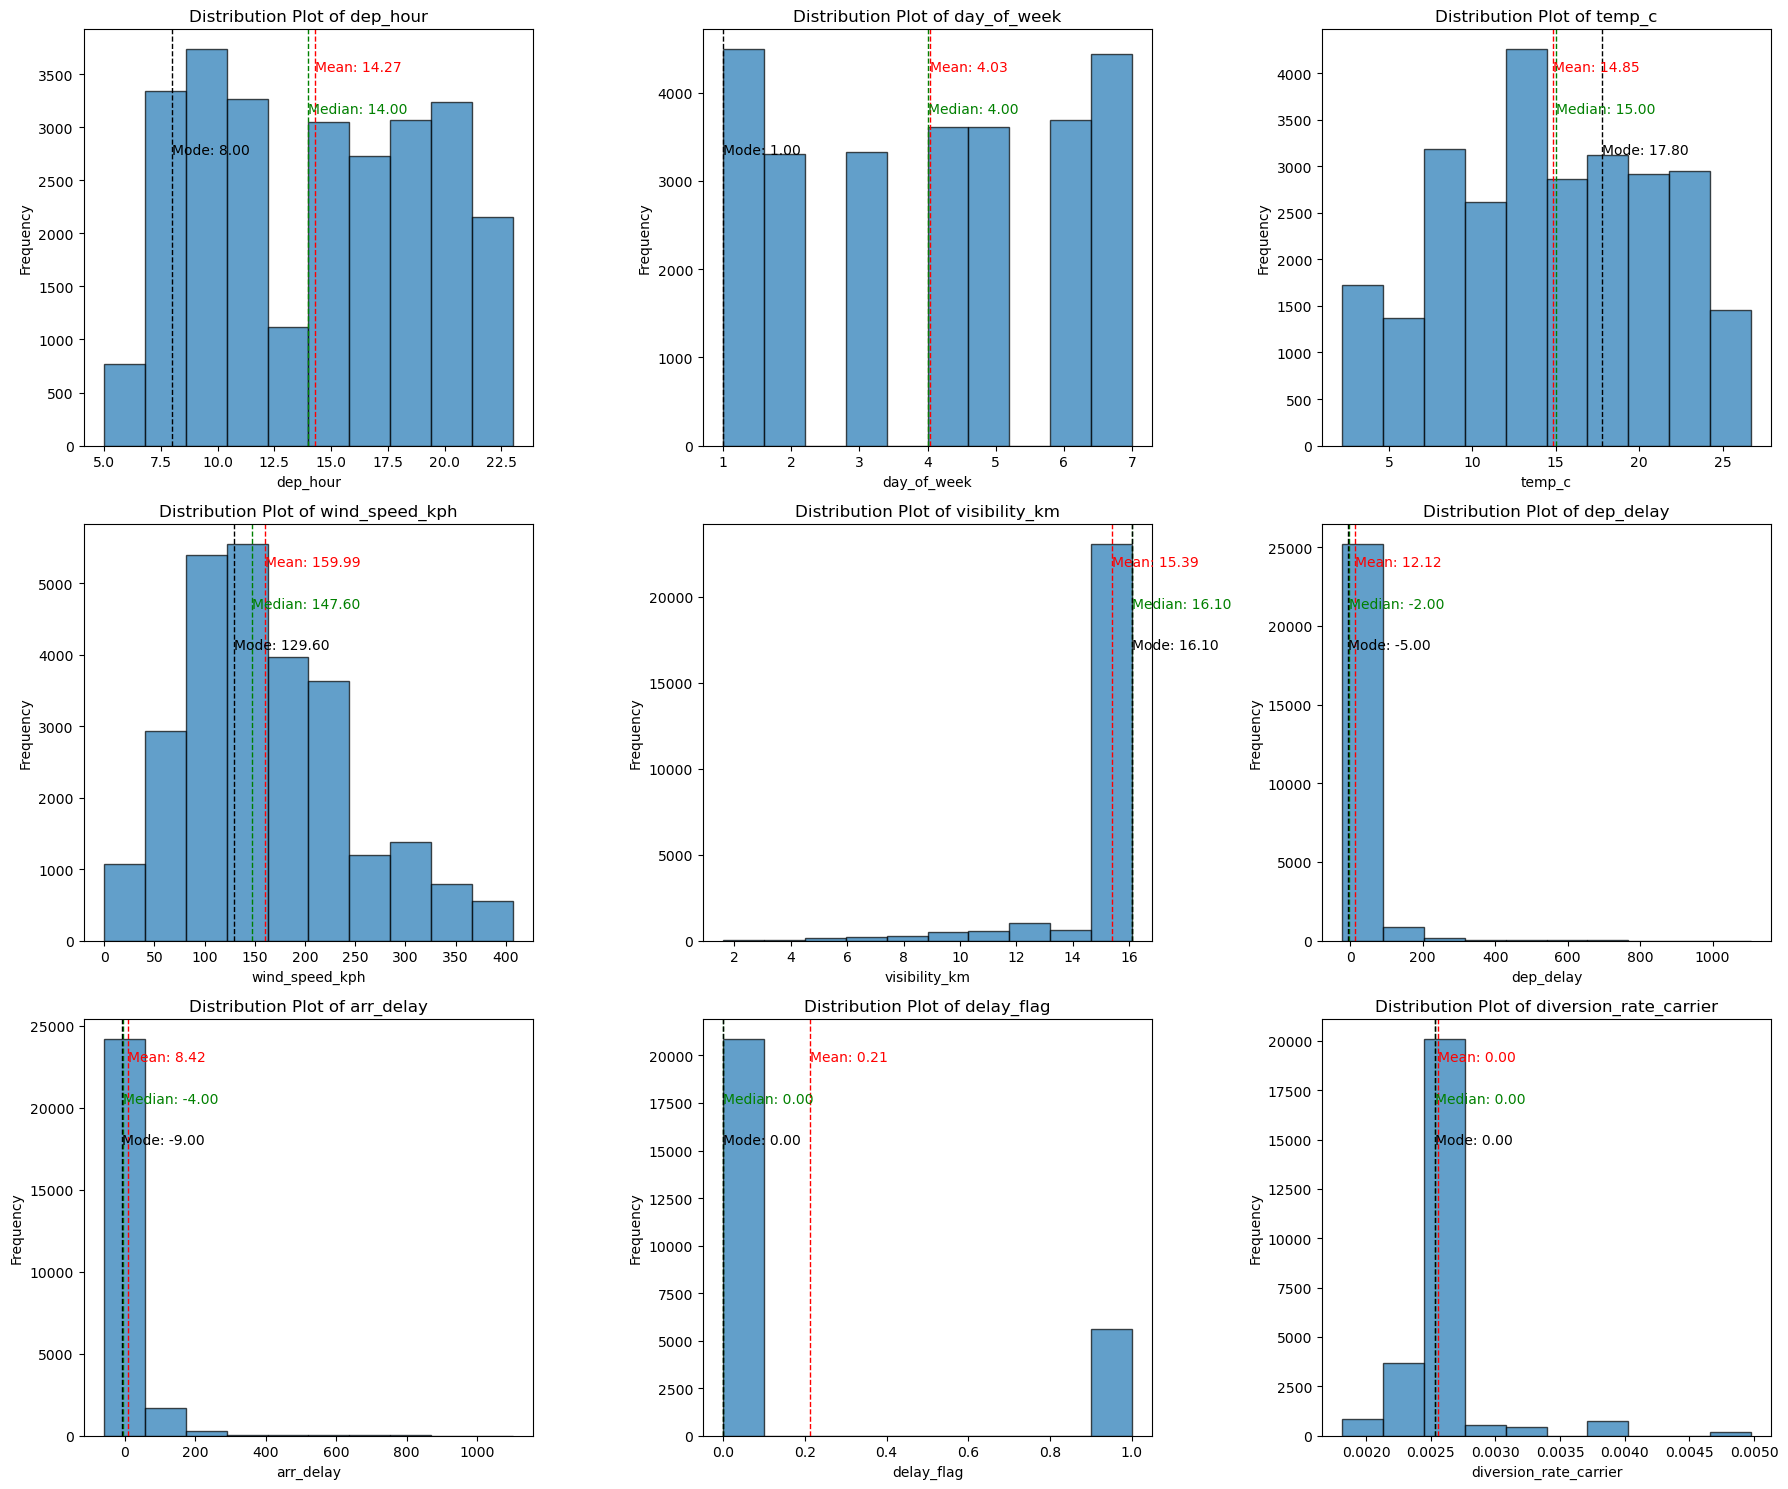

In [20]:
plot_histo(numeri_df,numeri_df.columns)

# Obervations: 

## dep_hour and day_of_week
### Fairly uniform distribution across hours and days.
### No major gaps → good coverage of time.

## temp_c
### Mostly between 10–20°C, peaking around 15°C
### Clean distribution → no extreme outliers

## wind_speed_kph
### Centered around 150 km/h, tails up to ~400 km/h
### will cap at 350 to remove rare spikes

## visibility_km
### Most values at the sensor max (16.1 km) → very little variation

## dep_delay and arr_delay
### Long right tail (heavy delays), many values < 0 (early departures)
### Skewed → will applly log-transform or other transformation 

## delay_flag
### Class imbalance: ~21% delayed, 79% not delayed
### we need do resampling or weighted loss

## diversion_rate_origin and diversion_rate_carrier
### Extremely left-skewed and low variation
### Likely weak features unless there are outlier airports/carriers

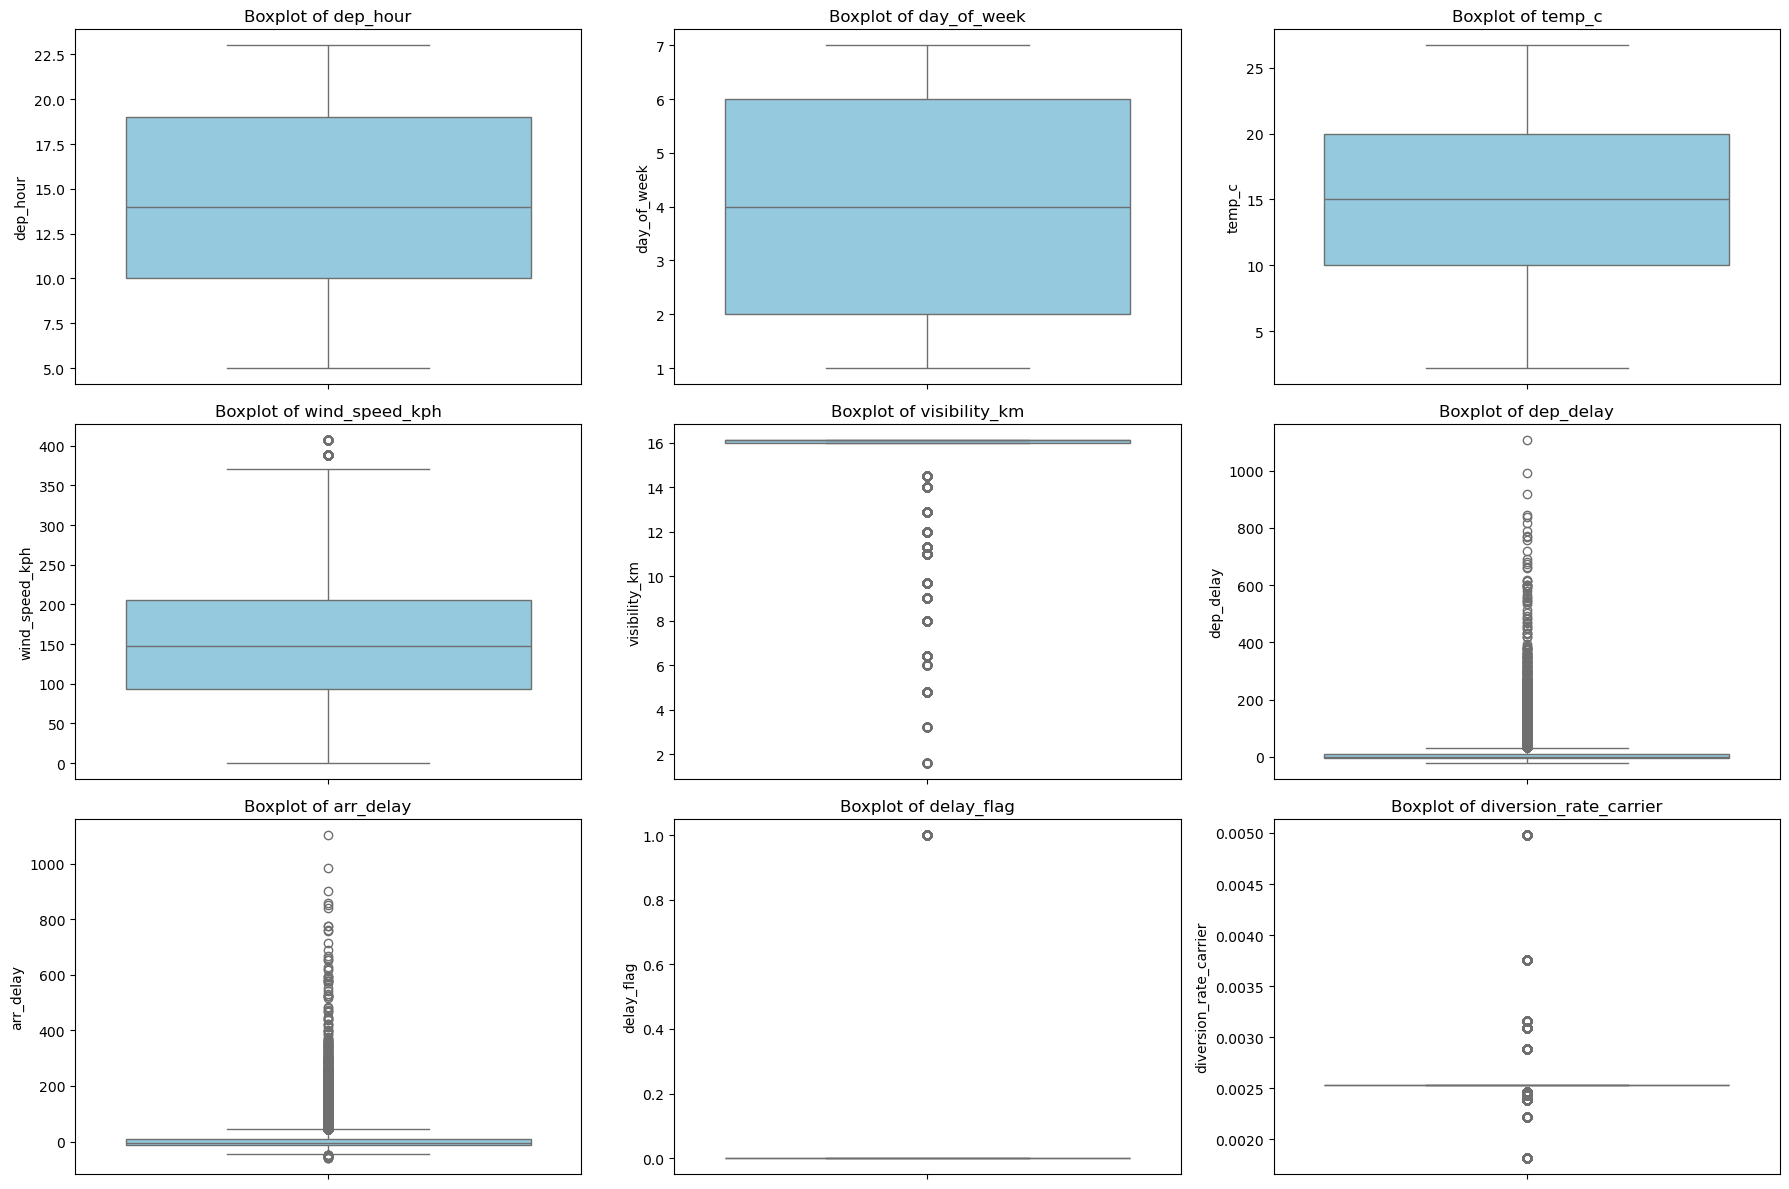

In [21]:
plot_boxplots(df)

### Outler Observations

### Features with No Concerning Outliers:
### dep_hour, day_of_week, temp_c – All well-bounded
### delay_flag – Expected binary distribution (0 or 1)

### Features with Noticeable Outliers:
### wind_speed_kph : A few extreme spikes > 350 km/h – possibly erroneous (we will cap at 350)
### visibility_km : Heavy concentration at sensor max (16.1) – typical in real-world weather datasets, and less visibility is possible at wintes 
### dep_delay & arr_delay : Strong long right tail with extreme delays up to ~1000 min – we will do capping at 500 min to handle extreme cases
### diversion_rate_carrier : Very tightly clustered, but some small outliers, maybe due airlines with very few number of flights or 

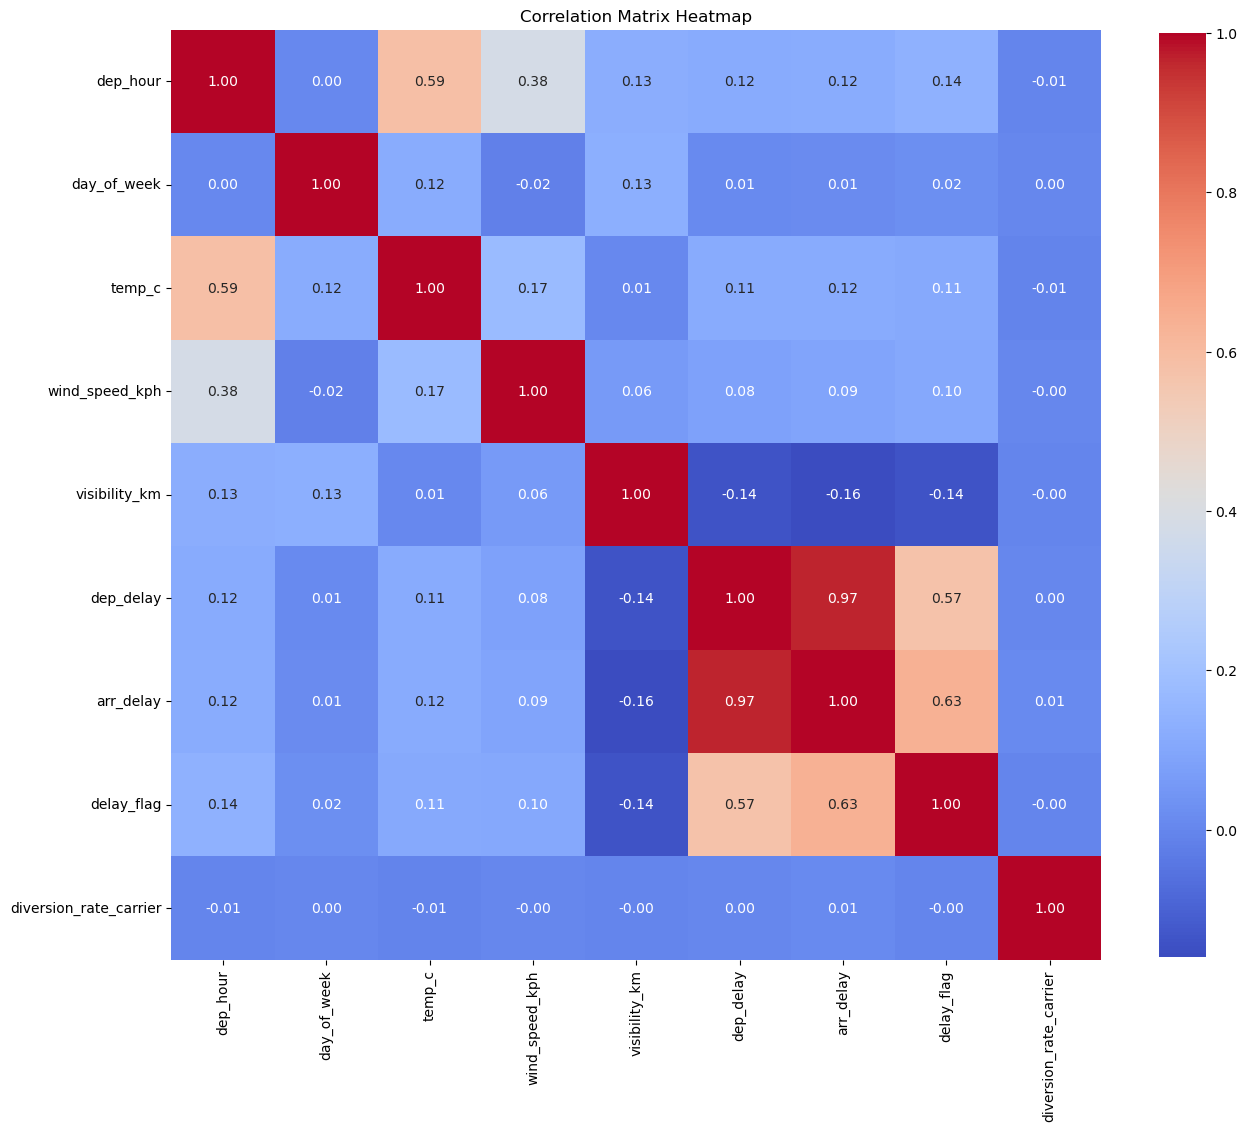

In [22]:
numerical_df = df.select_dtypes(include=['number'])
# Calculate the correlation matrix
corr_matrix = numerical_df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Matrix Heatmap')
plt.show()

## Correlation Matrix Observations:
### Strong Positive Correlations

### dep_delay & arr_delay : 0.96 : High multicollinearity; expected since departure delays usually cause arrival delays
### arr_delay & delay_flag : 0.67 :	Logical, since delay_flag = 1 if arr_delay > 15
### dep_delay & delay_flag : 0.61 : Also expected — late departures often lead to delayed arrivals
### here we used arr_delay is used to create our target variable, so we will not use dep_delay in our model
### arr_delay & dep_delay has very high multicollinearity, this will cause indirect target leakage so will not use dep_delay in our model

### Moderate/Low Positive Correlations
### dep_hour & temp_c : 0.59 : Warmer temps later in the day
### dep_hour & wind_speed_kph :	0.39 : Wind tends to rise during day

### Very Weak/No Correlation
### day_of_week with anything	~0	No weekly trend in delays/temps
### diversion_rate_carrier with	All features	~0

## lets Explore the Non Numeric data 

In [23]:
df_catagorical = df.select_dtypes(include=['object'])

In [24]:
df.columns

Index(['flight_date', 'carrier_code', 'origin', 'destination', 'dep_hour',
       'day_of_week', 'temp_c', 'wind_speed_kph', 'visibility_km',
       'weather_code', 'dep_delay', 'arr_delay', 'delay_flag',
       'diversion_rate_carrier'],
      dtype='object')

In [25]:
df_catagorical.columns

Index(['flight_date', 'carrier_code', 'origin', 'destination', 'weather_code'], dtype='object')

### lets convert dep_hour and day_of_week to catagorical.
### also lets drop flight_date as we have day and week data to capture any seasonal trends 

In [26]:
df = df.drop(columns=['flight_date'], axis=1)

In [27]:
df[['dep_hour', 'day_of_week']] = df[['dep_hour', 'day_of_week']].astype('object')
df_catagorical = df.select_dtypes(include=['object'])

In [28]:
# Print number of unique values per categorical column
for col in df_catagorical.columns:
    print(f"{col}: {df_catagorical[col].nunique()} unique values")

carrier_code: 12 unique values
origin: 1 unique values
destination: 136 unique values
dep_hour: 19 unique values
day_of_week: 7 unique values
weather_code: 1 unique values


## we only have one unique values for Origin (as we are only taking one origin) and weather_code, we will drop these

In [29]:
df=df.drop(columns=['origin','weather_code'],axis=1)
df_catagorical = df_catagorical.drop(columns=['origin','weather_code'],axis=1)

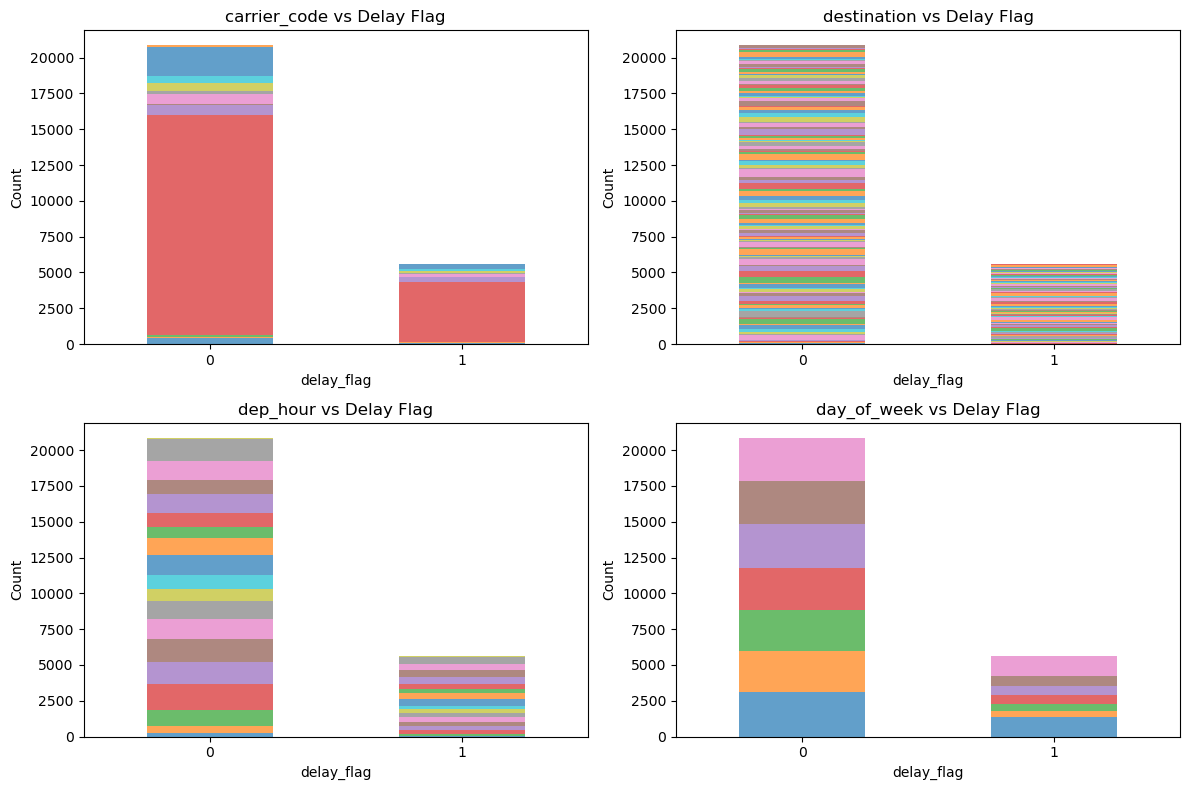

In [30]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

ncols = 2
nrows = (len(categorical_cols) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    grouped = df.groupby(['delay_flag', col]).size().unstack(fill_value=0)

    # Suppress legend to avoid clutter
    grouped.plot(kind='bar', stacked=True, ax=axes[i], alpha=0.7, legend=False)

    axes[i].set_title(f'{col} vs Delay Flag')
    axes[i].set_xlabel('delay_flag')
    axes[i].set_ylabel('Count')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [31]:
# Print number of unique values per categorical column
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df.select_dtypes(include=['object'])[col].nunique()} unique values")

carrier_code: 12 unique values
destination: 136 unique values
dep_hour: 19 unique values
day_of_week: 7 unique values


## Catagorical Features Oberservations:
### carrier_code vs delay_flag
### One airline (likely DL or AA) has a huge share of total flights — dominant in both delayed and non-delayed cases.
### However, relative proportions suggest some carriers have higher delay rates.

### destination vs delay_flag
### Most destinations appear fairly evenly distributed across delay classes.
### Some destinations may have slightly higher relative delays, but nothing striking in the visual.

### dep_hour vs delay_flag
### The distribution shows flights across all hours
### Possible operational congestion during peak hours.

### day_of_week vs delay_flag
### All weekdays are represented fairly equally.



## Final EDA Observations

###  Data Cleaning & Feature Decisions
- Dropped `arr_delay` and `dep_delay` to prevent **target leakage**.
- Dropped `flight_date`, `origin`, and `weather_code` due to **low variance** or **redundancy**.
- Converted `dep_hour` and `day_of_week` to **categorical** for encoding.

---

### Categorical Feature Insights
- **`carrier_code`** shows variation in delay rates — a useful predictor.
- **`destination`** has high cardinality — will group rare values under `'Other'`.
- **`dep_hour`** and **`day_of_week`** show good value distribution and are retained.

---

### Numerical Feature Observations
- **`temp_c`**: Well distributed, no extreme outliers.
- **`wind_speed_kph`**: Outliers beyond 350 km/h — will be capped at 350.
- **`visibility_km`**: Most values at sensor max (16.1 km) — expected behavior.

---

###  Outliers
- `dep_delay` and `arr_delay` were heavily skewed.
- Mild outliers present in `wind_speed_kph` and `diversion_rate_carrier`.

---

###  Correlation Matrix Insights
- `arr_delay`, `dep_delay`, and `delay_flag` are **highly correlated**:
  - `arr_delay` used to derive `delay_flag` → dropped.
  - `dep_delay` also dropped to avoid indirect leakage.
- Other features show low to moderate correlation — **no major multicollinearity**.

---

###  Class Imbalance
- `delay_flag`: ~21% delayed vs ~79% not delayed.
- Will require handling via **resampling** (e.g., SMOTE) or **class-weighted modeling**.

---


## Pre-Processing

### lets split our data to avoid target leakage

In [32]:
df.columns

Index(['carrier_code', 'destination', 'dep_hour', 'day_of_week', 'temp_c',
       'wind_speed_kph', 'visibility_km', 'dep_delay', 'arr_delay',
       'delay_flag', 'diversion_rate_carrier'],
      dtype='object')

In [33]:
y= df['delay_flag']
X= df.drop(columns=['delay_flag','dep_delay','arr_delay'],axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test,X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42, stratify=y_test) 

In [35]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((21174, 8), (4235, 8), (1059, 8), (21174,), (4235,), (1059,))

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21174 entries, 2259 to 5630
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   carrier_code            21174 non-null  object 
 1   destination             21174 non-null  object 
 2   dep_hour                21174 non-null  object 
 3   day_of_week             21174 non-null  object 
 4   temp_c                  21174 non-null  float64
 5   wind_speed_kph          21174 non-null  float64
 6   visibility_km           21174 non-null  float64
 7   diversion_rate_carrier  21174 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.5+ MB


### we will cap the outliers here only on training data to simulate real world test and validation data

In [37]:
def cap_outliers(df):
    df = df.copy()
    # Cap wind speed
    df['wind_speed_kph'] = df['wind_speed_kph'].clip(upper=350)
    return df

In [38]:
X_train=cap_outliers(X_train)

In [39]:
# Select object (categorical) columns
object_cols = X_train.select_dtypes(include='object').columns

# Print number of unique values per categorical column
for col in object_cols:
    print(f"{col}: {X_train[col].nunique()} unique values")

carrier_code: 12 unique values
destination: 136 unique values
dep_hour: 19 unique values
day_of_week: 7 unique values


### we have more values in destination, so to handel rare cases we will group rare cases and replcae them with 'other'

In [40]:
# Handle rare destinations
# Identify rare destination values in training data (frequency < 100)
rare_destinations = X_train['destination'].value_counts()
rare_destinations = rare_destinations[rare_destinations < 100].index

def replace_rare_destinations(df, rare_values):
    return df['destination'].apply(lambda x: 'Other' if x in rare_values else x)

# Apply the replacement
X_train['destination'] = replace_rare_destinations(X_train, rare_destinations)
X_val['destination'] = replace_rare_destinations(X_val, rare_destinations)
X_test['destination'] = replace_rare_destinations(X_test, rare_destinations)


In [41]:
print(f"destination: {X_train['destination'].nunique()} unique values")

destination: 71 unique values


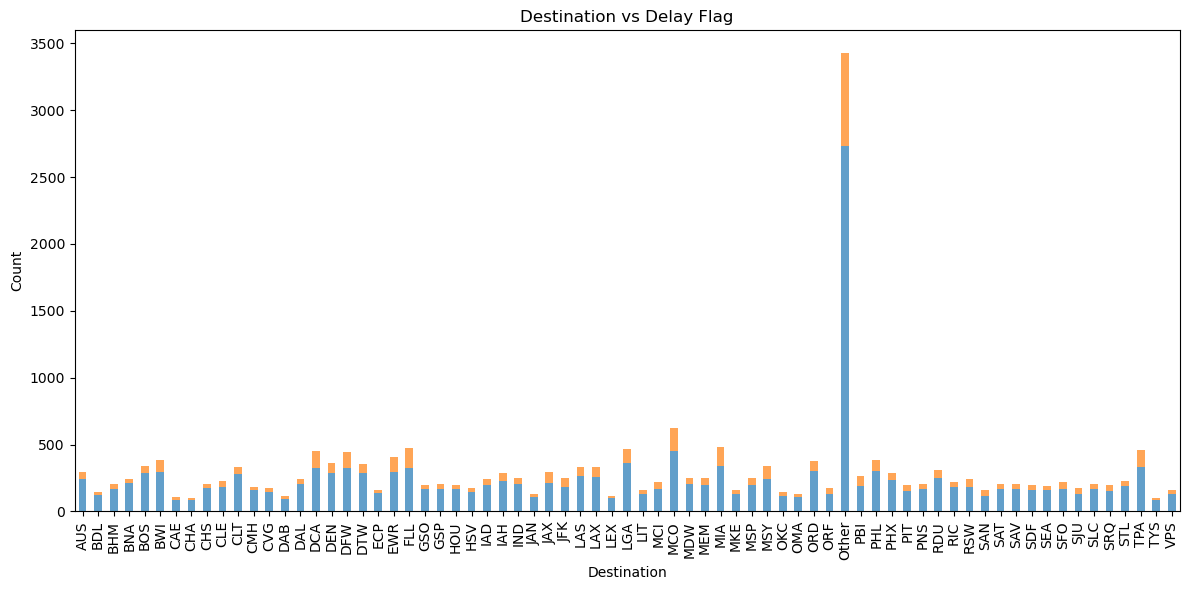

In [42]:
# Temporarily merge X_train and y_train for plotting
plot_df = X_train.copy()
plot_df['delay_flag'] = y_train.values  # align target with features

# Group and plot
grouped = plot_df.groupby(['destination', 'delay_flag']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 6))
grouped.plot(kind='bar', stacked=True, ax=ax, alpha=0.7, legend=False)

ax.set_title('Destination vs Delay Flag')
ax.set_xlabel('Destination')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


In [43]:
X_train.info()
X_val.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21174 entries, 2259 to 5630
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   carrier_code            21174 non-null  object 
 1   destination             21174 non-null  object 
 2   dep_hour                21174 non-null  object 
 3   day_of_week             21174 non-null  object 
 4   temp_c                  21174 non-null  float64
 5   wind_speed_kph          21174 non-null  float64
 6   visibility_km           21174 non-null  float64
 7   diversion_rate_carrier  21174 non-null  float64
dtypes: float64(4), object(4)
memory usage: 1.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1059 entries, 17587 to 8470
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   carrier_code            1059 non-null   object 
 1   destination             1059 non-null   obje

In [44]:
#  Define categorical columns for encoding
cat_cols = X_train.select_dtypes(include='object').columns.tolist()

#  One-Hot Encode
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on train and transform all
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_train.index)
X_val_encoded = pd.DataFrame(encoder.transform(X_val[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_val.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[cat_cols]), columns=encoder.get_feature_names_out(cat_cols), index=X_test.index)

#  Drop original categorical columns and merge encoded
X_train_final = pd.concat([X_train.drop(columns=cat_cols), X_train_encoded], axis=1)
X_val_final = pd.concat([X_val.drop(columns=cat_cols), X_val_encoded], axis=1)
X_test_final = pd.concat([X_test.drop(columns=cat_cols), X_test_encoded], axis=1)

In [45]:
X_train_final.shape, X_val_final.shape, X_test_final.shape

((21174, 113), (1059, 113), (4235, 113))

In [46]:
dataframes=[X_train_final, X_val_final, X_test_final, y_train, y_val, y_test]
for df in dataframes:
    print(f"\nNull values in DataFrame:")
    null_values(df)


Null values in DataFrame:

113 columns have no null values.


Null values in DataFrame:

113 columns have no null values.


Null values in DataFrame:

113 columns have no null values.


Null values in DataFrame:

1 columns have no null values.


Null values in DataFrame:

1 columns have no null values.


Null values in DataFrame:

1 columns have no null values.



## Lets do Scaling 

In [47]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21174 entries, 2259 to 5630
Columns: 113 entries, temp_c to day_of_week_7
dtypes: float64(113)
memory usage: 18.4 MB


In [48]:
scaler = StandardScaler()

# Fit and transform training set
X_train_final_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_final),
    columns=X_train_final.columns,
    index=X_train_final.index
)

# Transform validation and test sets
X_val_final_scaled = pd.DataFrame(
    scaler.transform(X_val_final),
    columns=X_val_final.columns,
    index=X_val_final.index
)

X_test_final_scaled = pd.DataFrame(
    scaler.transform(X_test_final),
    columns=X_test_final.columns,
    index=X_test_final.index
)

In [49]:
X_train_final = X_train_final_scaled
X_val_final = X_val_final_scaled
X_test_final = X_test_final_scaled

In [50]:
X_train_final.sample(5)

,temp_c,wind_speed_kph,visibility_km,diversion_rate_carrier,carrier_code_AA,carrier_code_AS,carrier_code_B6,carrier_code_DL,carrier_code_F9,carrier_code_MQ,...,dep_hour_21,dep_hour_22,dep_hour_23,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7
1560,-0.336815,-0.362848,0.343704,-0.066081,-0.140869,-0.061969,-0.080995,0.594623,-0.207866,-0.060806,...,-0.266997,3.460385,-0.061584,-0.450252,-0.378556,-0.379941,-0.399002,-0.396613,-0.400512,2.221729
24651,1.183154,0.074609,0.343704,-0.066081,-0.140869,-0.061969,-0.080995,0.594623,-0.207866,-0.060806,...,-0.266997,3.460385,-0.061584,-0.450252,-0.378556,-0.379941,-0.399002,-0.396613,2.496804,-0.450100
10299,-0.255966,-0.581576,0.343704,-0.066081,-0.140869,-0.061969,-0.080995,0.594623,-0.207866,-0.060806,...,-0.266997,-0.288985,-0.061584,-0.450252,-0.378556,-0.379941,2.506251,-0.396613,-0.400512,-0.450100
22479,-0.158947,-0.362848,0.343704,-0.066081,-0.140869,-0.061969,-0.080995,0.594623,-0.207866,-0.060806,...,-0.266997,-0.288985,-0.061584,-0.450252,-0.378556,-0.379941,2.506251,-0.396613,-0.400512,-0.450100
11133,-0.078097,-1.019033,0.295740,-0.282124,-0.140869,-0.061969,-0.080995,-1.681737,-0.207866,-0.060806,...,-0.266997,-0.288985,-0.061584,-0.450252,-0.378556,-0.379941,-0.399002,2.521347,-0.400512,-0.450100


## Lets check class seperability using T-SNE and UMAP

In [52]:
# Step 1: PCA to retain 90% variance
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_train_final)

print(f"PCA-reduced shape: {X_pca.shape}")

PCA-reduced shape: (21174, 3)


## As TSNE is heavy process lets just run this on sample 

In [53]:
# Stratified sample: take 5000 points with class balance
X_sample, _, y_sample, _ = train_test_split(
    X_pca, y_train, 
    train_size=5000, 
    stratify=y_train, 
    random_state=42
)

c:\Users\DELL\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


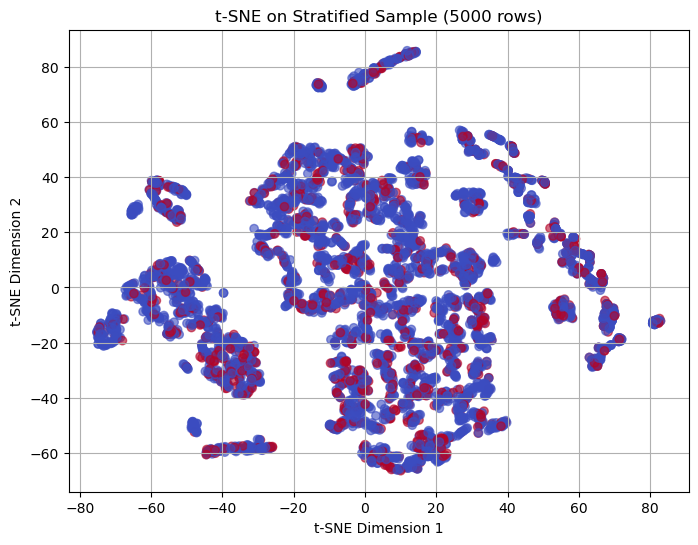

In [56]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_sample = tsne.fit_transform(X_sample)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne_sample[:, 0], X_tsne_sample[:, 1], c=y_sample, cmap='coolwarm', alpha=0.6)
plt.title("t-SNE on Stratified Sample (5000 rows)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


c:\Users\DELL\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


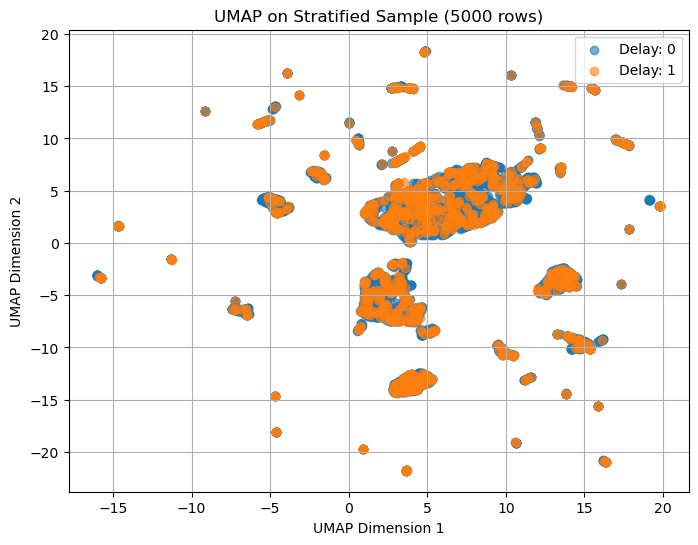

In [58]:
# UMAP projection to 2D
umap_reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_reducer.fit_transform(X_sample)

# Plot
plt.figure(figsize=(8, 6))
for label in np.unique(y_sample):
    idx = y_sample == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], 
                label=f"Delay: {label}", alpha=0.6)

plt.title("UMAP on Stratified Sample (5000 rows)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


### Observations (Stratified Sample of 5000 Rows)

1. **UMAP formed clear clusters**  
   - The data points are grouped into compact areas, showing some structure in the features.

2. **Delay and non-delay classes overlap**  
   - Both classes are mixed across most clusters.  
   - This means the current features don’t cleanly separate delayed vs. non-delayed flights.

3. **Some regions show slight class separation**  
   - A few clusters have more delayed or non-delayed points, but not strongly.

4. **Implication for modeling**  
   - Linear models may struggle to separate classes.  
   - Nonlinear models like Random Forest or XGBoost may perform better.  
   - Feature engineering might help improve separation.


## Lets save all the files and Preprocessing Objects

In [61]:
import os
import joblib

# Create parent directory if it doesn't exist
os.makedirs("../model_training", exist_ok=True)

# --- 1. Save Pre-Encoding Raw Feature DataFrames ---
X_train.to_csv("../model_training/X_train_raw.csv", index=False)
X_val.to_csv("../model_training/X_val_raw.csv", index=False)
X_test.to_csv("../model_training/X_test_raw.csv", index=False)

# --- 2. Save Encoded + Scaled Feature DataFrames ---
X_train_final.to_csv("../model_training/X_train.csv", index=False)
X_val_final.to_csv("../model_training/X_val.csv", index=False)
X_test_final.to_csv("../model_training/X_test.csv", index=False)

# --- 3. Save Target Variables ---
y_train.to_csv("../model_training/y_train.csv", index=False)
y_val.to_csv("../model_training/y_val.csv", index=False)
y_test.to_csv("../model_training/y_test.csv", index=False)

# --- 4. Save Fitted Preprocessing Objects ---
joblib.dump(encoder, "../model_training/ohe_encoder.pkl")
joblib.dump(scaler, "../model_training/standard_scaler.pkl")

# --- 5. Save Feature Metadata ---
original_feature_names = X_train.columns.tolist()
joblib.dump(original_feature_names, "../model_training/original_feature_names.pkl")
joblib.dump(cat_cols, "../model_training/categorical_columns.pkl")
joblib.dump(rare_destinations, "../model_training/rare_destinations.pkl")


['../model_training/rare_destinations.pkl']